In [283]:
#Run on GRIB_netCDF
#Followed: https://doi.org/10.3390/jmse8040289
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
from scipy.stats import weibull_min
from scipy.stats import lognorm
from scipy.stats import norm
from scipy.stats import genpareto
from tqdm import tqdm
from scipy.spatial import ConvexHull
import h5py
import pandas as pd
from functools import partial

from scipy.optimize import curve_fit
from multiprocessing import Pool

sys.path.append('./Tools')
from Port_Opt_Tools import GetOverlaps_Idx_Area
from GeneralGeoTools import PlotGeneralGeoData_Class, PlotGeneralGeoData

sys.path.append('./Tools/Multiprocessing')
from EVA_WaveWind import ComputeExtremeSurface_Multiprocessing

PathWaveDate="./InputData/Wave/WWIII_2005_2019.npz"
GeoDataPath="./InputData/CoastLine/"

#Wave Data
Npz_Wave=np.load(PathWaveDate, allow_pickle=True)
WaveLatLong=Npz_Wave["LatLong"]
Hs=Npz_Wave["Hs"]
Tp=Npz_Wave["Tp"]
WaveDepth=Npz_Wave["Depth"]

WaveDistanceShore=Npz_Wave["DistanceShore"]
WaveDTime=list(Npz_Wave["DateTimeList"])
NumYearsWaveData=(WaveDTime[-1]-WaveDTime[0]).days/365

IdxIn=WaveDepth<200
WaveLatLong=WaveLatLong[IdxIn,:]
Hs=Hs[IdxIn,:]
Tp=Tp[IdxIn,:]
WaveDepth=WaveDepth[IdxIn]
WaveDistanceShore=WaveDistanceShore[IdxIn]


# POT- EVA Hs 

In [288]:
#Get the samples to do the EVA using POT method
ThresholdWave=99.5 #Threshold for the wave data
Threshold_HsSite=[]
EVA_Hs_Samples_site=[]# Samples of Hs that violate the threshold for each site
for s in range(len(Hs)):
    SamplesViolateThreshold=[]
    P_99=np.percentile(Hs[s,:],ThresholdWave)
    Threshold_HsSite.append(P_99)
    IdxViolated=np.where(Hs[s,:]>=P_99)[0]
    Hs_tmp=Hs[s,IdxViolated]
    Date_tmp=[WaveDTime[i] for i in IdxViolated]
    
    #if difference between consecute observatios is more than 24h we have a new event
    Date_s=Date_tmp[0] #Start Date fo Extreme Event
    Date_e=Date_s #End Date of Extreme Event
    for date in Date_tmp[1:]:
        if (date-Date_e).total_seconds()/3600<=24*2:
            Date_e=date
        else:
            SamplesViolateThreshold.append(np.max(Hs_tmp[Date_tmp.index(Date_s):Date_tmp.index(Date_e)+1])) #Maxmimum value of the event (Hs)
            Date_s=date #Start Date of the New Event
            Date_e=Date_s
    
    EVA_Hs_Samples_site.append(SamplesViolateThreshold) #Each site may have a different number of violations

#Check the Max-Min and Average Number of Events and print
MinNumEvents=min([len(EVA_Hs_Samples_site[i]) for i in range(len(EVA_Hs_Samples_site))])
MaxNumEvents=max([len(EVA_Hs_Samples_site[i]) for i in range(len(EVA_Hs_Samples_site))])
MeanNumEvents=np.average([len(EVA_Hs_Samples_site[i]) for i in range(len(EVA_Hs_Samples_site))])
print("MinNumEvents : ", MinNumEvents)
print("MaxNumEvents : ", MaxNumEvents)
print("MeanNumEvents: ", MeanNumEvents)


MinNumEvents :  27
MaxNumEvents :  52
MeanNumEvents:  38.5173116089613


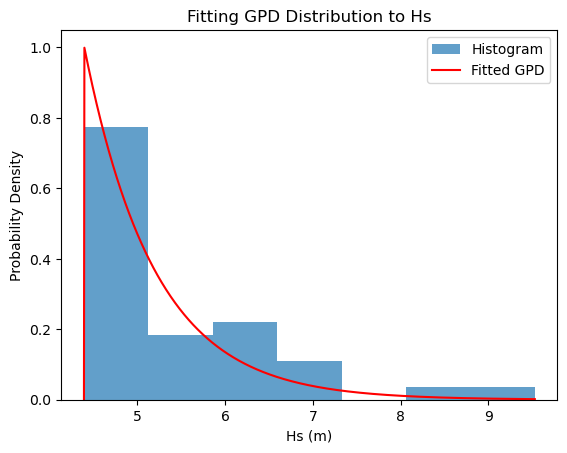

(9.999999999728554e-05, 4.394389999999987, 0.8016717905175925)

In [362]:
def GPD_pdf(x, c, loc, scale):
    x=(x-loc)/scale
    return genpareto.pdf(x, c)

def GPD_INV_CDF(q, c, loc, scale):
    x=genpareto.ppf(q, c)
    x=x*scale+loc
    return x

def EVA_Hs (s,EVA_Hs_Samples_site=EVA_Hs_Samples_site,Threshold_HsSite=Threshold_HsSite, PlotFig=False):
    

    Hs_i=EVA_Hs_Samples_site[s]

    # Create bins and histogram
    bins = np.linspace(min(Hs_i), max(Hs_i), 500)
    hist, bin_edges = np.histogram(Hs_i, bins=bins, density=True)

    # Get the x values (midpoints of bins)
    x_values = (bin_edges[:-1] + bin_edges[1:]) / 2
        
    params, covariance = curve_fit(GPD_pdf, x_values, hist, maxfev=2000,bounds=([0,Threshold_HsSite[s]*0.999,0], [0.0001, Threshold_HsSite[s]*1.001, 10]))

    # Extract the fitted parameters
    shape, loc, scale = params

    # Create a range of values for plotting
    x_values = np.linspace(min(Hs_i), max(Hs_i), 1000)

    if PlotFig==True:
        # Plot the histogram of the data
        plt.hist(Hs_i, bins=7, density=True, alpha=0.7, label='Histogram')

        # Plot the fitted Weibull distribution
        plt.plot(x_values, GPD_pdf(x_values, shape, loc, scale ), 'r-', label='Fitted GPD')

        plt.legend()
        plt.title('Fitting GPD Distribution to Hs')
        plt.xlabel('Hs (m)')  
        plt.ylabel('Probability Density')
        plt.show()
    return shape, loc, scale

EVA_Hs (400,PlotFig=True) 

In [363]:
#Get Parameters for all locations
EVA_Hs_Params=[]
EVA_Hs_50Yrs=[]
EVA_Hs_100Yrs=[]
for s in tqdm(range(len(EVA_Hs_Samples_site))):
    shape, loc, scale=EVA_Hs (s,PlotFig=False)
    EVA_Hs_Params.append([shape, loc, scale])

    Hs_50yr=GPD_INV_CDF(1-1/(len(EVA_Hs_Samples_site[0])/NumYearsWaveData*50),EVA_Hs_Params[s][0],EVA_Hs_Params[s][1],EVA_Hs_Params[s][2])
    Hs_100yr=GPD_INV_CDF(1-1/(len(EVA_Hs_Samples_site[0])/NumYearsWaveData*100),EVA_Hs_Params[s][0],EVA_Hs_Params[s][1],EVA_Hs_Params[s][2])

    EVA_Hs_50Yrs.append(Hs_50yr)
    EVA_Hs_100Yrs.append(Hs_100yr)
    

100%|██████████| 491/491 [00:04<00:00, 107.62it/s]


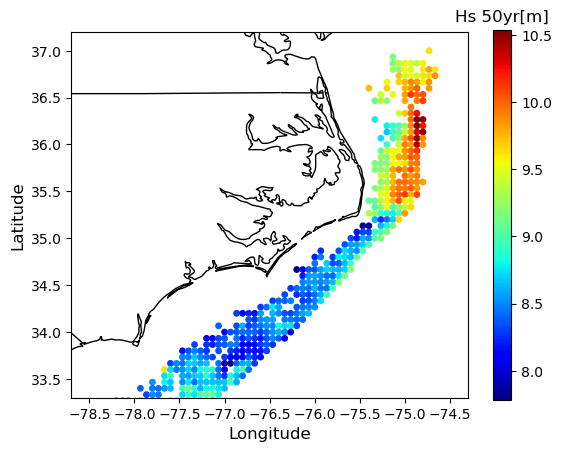

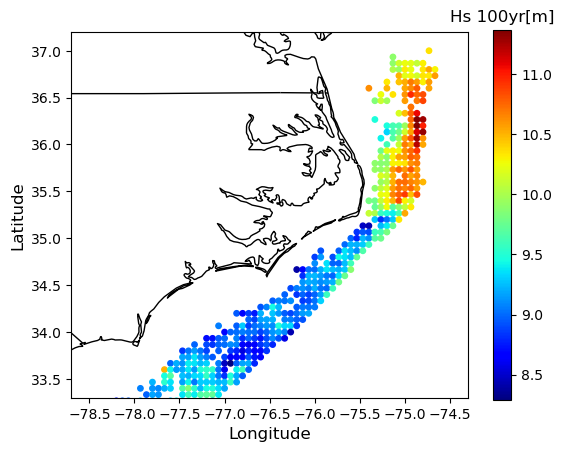

In [364]:
PlotGeneralGeoData(WaveLatLong, EVA_Hs_50Yrs, GeoDataPath, ColorBarTitle="Hs 50yr[m]", Title=None, SavePath=None, s=15, LatMaxMin=(33.3, 37.2), LongMaxMin=(-78.7, -74.3))
PlotGeneralGeoData(WaveLatLong, EVA_Hs_100Yrs, GeoDataPath, ColorBarTitle="Hs 100yr[m]", Title=None, SavePath=None, s=15, LatMaxMin=(33.3, 37.2), LongMaxMin=(-78.7, -74.3))

(array([0.05299089, 0.06623861, 0.23845899, 0.41067937, 1.02007458,
        0.92734052, 0.67563381, 0.4239271 , 0.37093621, 0.26495444,
        0.3046976 , 0.21196355, 0.22521127, 0.25170671, 0.39743165,
        0.34444077, 0.17222038, 0.03974317, 0.03974317, 0.06623861]),
 array([ 8.29254671,  8.44628332,  8.60001993,  8.75375655,  8.90749316,
         9.06122977,  9.21496639,  9.368703  ,  9.52243961,  9.67617623,
         9.82991284,  9.98364945, 10.13738607, 10.29112268, 10.44485929,
        10.59859591, 10.75233252, 10.90606913, 11.05980575, 11.21354236,
        11.36727897]),
 <BarContainer object of 20 artists>)

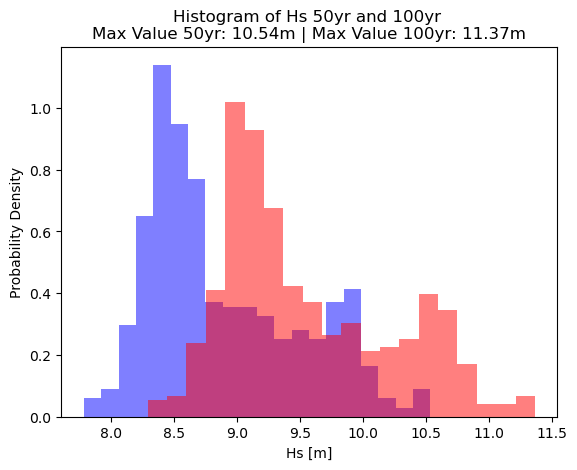

In [365]:
#Plot Histogram of Hs 50yr for all site locations:
plt.title('Histogram of Hs 50yr and 100yr'+" \nMax Value 50yr: "+str(round(max(EVA_Hs_50Yrs),2))+"m"+" | Max Value 100yr: "+str(round(max(EVA_Hs_100Yrs),2))+"m")
plt.xlabel('Hs [m]')
plt.ylabel('Probability Density')
plt.hist(EVA_Hs_50Yrs, bins=20, density=True, alpha=0.5, label='50yr',color="b")
plt.hist(EVA_Hs_100Yrs, bins=20, density=True, alpha=0.5, label='100yr',color="r")


# Curve Hs / Tp

## f(HS)~ Two parameter Weibull

In [21]:
def Fit_Hs(Hs_i, PlotFig=False):
    def weibull_pdf(x, shape, loc, scale):
        return weibull_min.pdf(x, shape, loc=loc, scale=scale)

    # Define the probability density function (PDF) of the log-normal distribution
    def lognorm_pdf(x, s, loc, scale):
        return lognorm.pdf(x, s, loc=loc, scale=scale)
    
    # Create bins and histogram
    bins = np.linspace(min(Hs_i), max(Hs_i), 50)
    hist, bin_edges = np.histogram(Hs_i, bins=bins, density=True)

    # Get the x values (midpoints of bins)
    x_values = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit the Weibull distribution to the data using curve_fit
    params, covariance = curve_fit(lognorm_pdf, x_values, hist)
       
    # Extract the fitted parameters
    shape_Hs, loc_Hs, scale_Hs = params

    # Create a range of values for plotting
    x_values = np.linspace(min(Hs_i), max(Hs_i), 1000)

    if PlotFig==True:
        # Plot the histogram of the data
        plt.hist(Hs_i, bins=50, density=True, alpha=0.7, label='Histogram')

        # Plot the fitted Weibull distribution
        # plt.plot(x_values, lognorm_pdf(x_values, shape_Hs, loc_Hs, scale_Hs), 'r-', label='Fitted Weibull')
        plt.plot(x_values, lognorm_pdf(x_values, shape_Hs, loc_Hs, scale_Hs), 'r-', label='Fitted Log-Normal')

        plt.legend()
        # plt.title('Fitting Weibull Distribution to Wave Height')
        plt.title('Fitting Log-Normal Distribution to Wave Height')
        plt.xlabel('Hs (m)')  
        plt.ylabel('Probability Density')
        plt.show()

    return shape_Hs, loc_Hs, scale_Hs


ParamHs_Weibull=[]
for i in tqdm(range(Hs.shape[0])):
    Hs_i=Hs[i,:]
    ParamHs_Weibull.append(Fit_Hs(Hs_i))


100%|██████████| 732/732 [00:07<00:00, 98.56it/s] 


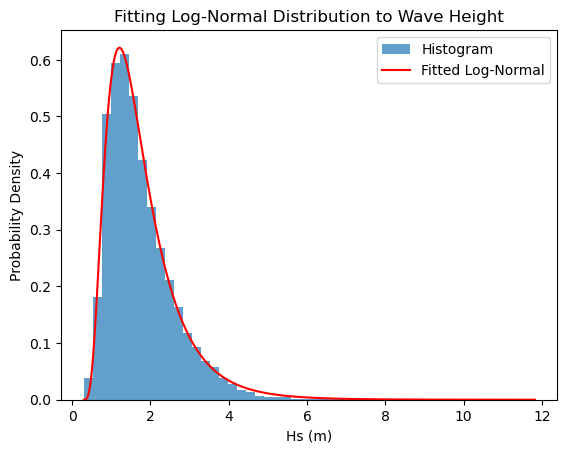

(0.5547488495743609, 0.21459084439003556, 1.3499133083592254)

In [23]:
SiteIdx=400
Hs_i=Hs[i,:]
Fit_Hs(Hs_i,PlotFig=True)

## F(Tp|Hs) ~ LogNormal Distribution/ or two parameter Weibull

In [68]:
def FitWeibull_TpHs(SiteIdx, Hs=Hs, Tp=Tp,  PlotFig=False):
    Hs_RefRange=[]
    Hs_RefRange.append(0)

    Hs_i=Hs[SiteIdx,:]
    Tp_i=Tp[SiteIdx,:]
    Params=[]
    #Validade Bin Range, it must have at least 1% of the data
    HsRange=0.1
    HsRange2=1
    
    for i in range(int(30/0.1)):
        
        Hs_r=(1+i)*HsRange
        R_data=np.sum((Hs[SiteIdx,:]>=Hs_r-HsRange2 ) * (Hs[SiteIdx,:]<Hs_r+HsRange2))/len(Hs[SiteIdx,:])
        if R_data>0.05:
            Hs_RefRange.append(Hs_r)
            
            
    Hs_RefRange=Hs_RefRange[:-1]
    Hs_RefRange.append(30) #jsut make sure that the last bin is big enough

    # Define the probability density function (PDF) of the log-normal distribution
    # def lognorm_pdf(x, s, loc, scale):
    #     return lognorm.pdf(x, s, loc=loc, scale=scale)

    def weibull_pdf(x, shape, loc, scale):
        return weibull_min.pdf(x, shape, loc=loc, scale=scale)
        # Define the probability density function (PDF) of the log-normal distribution
    def lognorm_pdf(x, s, loc, scale):
        return lognorm.pdf(x, s, loc=loc, scale=scale)
    
    c=0
    for i in range(len(Hs_RefRange[:-1])):
        IdxIn=(Hs[SiteIdx,:]>=Hs_RefRange[i]-HsRange2)* (Hs[SiteIdx,:]<Hs_RefRange[i+1]+HsRange2)
        Hs_i=Hs[SiteIdx,:]
        Hs_i=Hs_i[IdxIn]
        
        Tp_i=Tp[SiteIdx,:]
        Tp_i=Tp_i[IdxIn]
        

        # Create bins and histogram
        bins = np.linspace(min(Tp_i), max(Tp_i), 20)
        hist, bin_edges = np.histogram(Tp_i, bins=bins, density=True)

        # Get the x values (midpoints of bins)
        x_values = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Fit the log-normal distribution to the data using curve_fit
        params, covariance = curve_fit(weibull_pdf, x_values, hist,maxfev=10000 )

        # Extract the fitted parameters
        s, loc, scale = params
        Params.append([s, loc, scale])
        css4_colors = plt.get_cmap('tab20').colors 
        
        if PlotFig==True and i%7==0 and i>0:
            # Create a range of values for plotting
            x_values_plot = np.linspace(min(Tp_i), max(Tp_i), 1000)

            # Plot the histogram of the data
            plt.hist(Tp_i, bins=bins, density=True, alpha=0.7,color=css4_colors[c])

            # Plot the fitted log-normal distribution
            plt.plot(x_values_plot, weibull_pdf(x_values_plot, s, loc, scale),c=css4_colors[c],label="Hs: "+"{:.1f}".format(np.max([(Hs_RefRange[i]-HsRange2),0]))+"-"+"{:.1f}".format((Hs_RefRange[i]+HsRange2)))
            c+=1

    if PlotFig==True:
        plt.legend(frameon=False)
        plt.title('Fitting Weibull Distribution to Tp|Hs')
        # plt.title('Fitting Log-Normal Distribution to Tp|Hs')
        plt.xlabel('Tp (s)')
        plt.ylabel('Probability Density')
        plt.show()   
    
    return Params, Hs_RefRange

ParamTpHs=[]
Tp_Hs_RefRange=[]
for i in tqdm(range(Hs.shape[0])):
    Params, Hs_RefRange=FitWeibull_TpHs(i, PlotFig=False)
    ParamTpHs.append(Params)
    Tp_Hs_RefRange.append(Hs_RefRange)
    

100%|██████████| 732/732 [04:21<00:00,  2.80it/s]


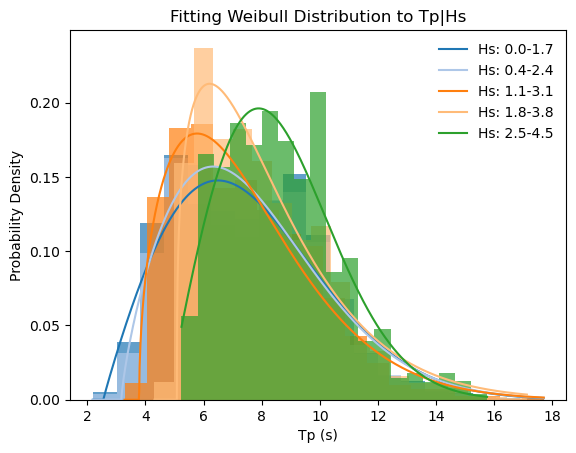

In [66]:
Params, Hs_RefRange=FitWeibull_TpHs(15, PlotFig=True)

In [69]:
Data={"ParamHs":ParamHs_Weibull, "ParamTpHs":ParamTpHs, "Tp_Hs_RefRange":Tp_Hs_RefRange}
np.savez("./InputData/Wave/EVA_Params.npz", Data=Data)

# Compute Extreme events (Hs ~Log-Normal, Tp ~Weibull)

In [71]:
Data=np.load("./InputData/Wave/EVA_Params.npz", allow_pickle=True)["Data"].item()
ParamHs=Data["ParamHs"]
ParamTpHs=Data["ParamTpHs"]
Tp_Hs_RefRange=Data["Tp_Hs_RefRange"]

In [4]:
# Here I am basing the theory on https://asmedigitalcollection.asme.org/offshoremechanics/article/137/3/031901/377037/Joint-Distribution-of-Environmental-Condition-at
#Rosenblatt transformation

#Definition on P(Hs)
Param_Hs=ParamHs

#Definition on P(Tp|Hs)
Param_Tp_Hs=ParamTpHs
Bins_Tp_Hs=Tp_Hs_RefRange

#range of values we will numerically investigate
Hp_EVA_Range=np.arange(0,40,0.2)
Tp_EVA_Range=np.arange(0,60,0.5)
NSites=len(Param_Hs)

def weibull_CDF(x, shape, loc, scale):
    return weibull_min.cdf(x, shape, loc=loc, scale=scale)

def lognorm_pdf(x, s, loc, scale):
    return lognorm.pdf(x, s, loc=loc, scale=scale)

#Extreme Surface for a Given Site
def ComputeExtremeSurface(s, Recurrency=50):
    #Definition on P(Hs)
    Param_Hs_s=Param_Hs[s]
    
    #Definition on P(Tp|Hs)
    Param_Tp_Hs_s=Param_Tp_Hs[s]
    Bins_Tp_Hs_s=np.array(Bins_Tp_Hs[s])

    ProbSurfaceVariables=[]
    ProbSurfaceValue=[]
    MaxRadius=norm.ppf(1-1/(365*24/3*Recurrency))
    
    MaxRadius2=MaxRadius**2
    for Ws_r in Ws_EVA_Range:
        
        #Wind
        y1=norm.ppf(weibull_CDF(Ws_r, Param_Ws_s[0], Param_Ws_s[1], Param_Ws_s[2]))
        if y1**2<=MaxRadius2:
            for Hp_r in Hp_EVA_Range:
                
                #Wave height
                #get index of the bin
                Idx_Hs_Ws_closest=np.max([np.argmax(Bins_Hs_Ws_s>=Ws_r)-1,0])
                Param_Hs_Ws_s_i=Param_Hs_Ws_s[Idx_Hs_Ws_closest]

                y2=norm.ppf(weibull_CDF(Hp_r, Param_Hs_Ws_s_i[0], Param_Hs_Ws_s_i[1], Param_Hs_Ws_s_i[2]))

                if y1**2+y2**2<=MaxRadius2:
                    for Tp_r in Tp_EVA_Range:
                        #Wave period
                        #get index of the bin
                        Idx_Tp_Hs_closest=np.max([np.argmax(Bins_Tp_Hs_s>=Hp_r)-1,0])
                        Param_Tp_Hs_s_i=Param_Tp_Hs_s[Idx_Tp_Hs_closest]

                        y3=norm.ppf(weibull_CDF(Tp_r, Param_Tp_Hs_s_i[0], Param_Tp_Hs_s_i[1], Param_Tp_Hs_s_i[2]))

                        r2=y1**2+y2**2+y3**2
                        if r2<=MaxRadius2:
                            ProbSurfaceVariables.append([Ws_r, Hp_r, Tp_r])
    
    return ProbSurfaceVariables

ProbSurfaceVariables=ComputeExtremeSurface(1)

# for s in tqdm(range(NSites)):
#     ComputeExtremeSurface(s)

In [5]:
IdxIn=list(range(NSites))

if __name__ == '__main__':
   with Pool(15) as p:
      Results = list(tqdm(p.imap(ComputeExtremeSurface_Multiprocessing, IdxIn), total=len(IdxIn)))

Data={"Results":Results}
np.savez("./InputData/Wave/EVA_50y_ProbSurfaceVariables.npz", Data=Data)

100%|██████████| 732/732 [36:29<00:00,  2.99s/it]  


In [7]:
IdxIn=list(range(NSites))
partial_func = partial(ComputeExtremeSurface_Multiprocessing, Recurrency=100)
if __name__ == '__main__':
   with Pool(16) as p:
      Results = list(tqdm(p.imap(partial_func, IdxIn), total=len(IdxIn)))

Data={"Results":Results}
np.savez("./InputData/Wave/EVA_100y_ProbSurfaceVariables.npz", Data=Data)

100%|██████████| 732/732 [38:11<00:00,  3.13s/it]  


# EVA Plots: Investigation

## 50 Yrs

In [8]:
Data=np.load("./InputData/Wave/EVA_50y_ProbSurfaceVariables.npz", allow_pickle=True)["Data"].item()
Results=Data["Results"]


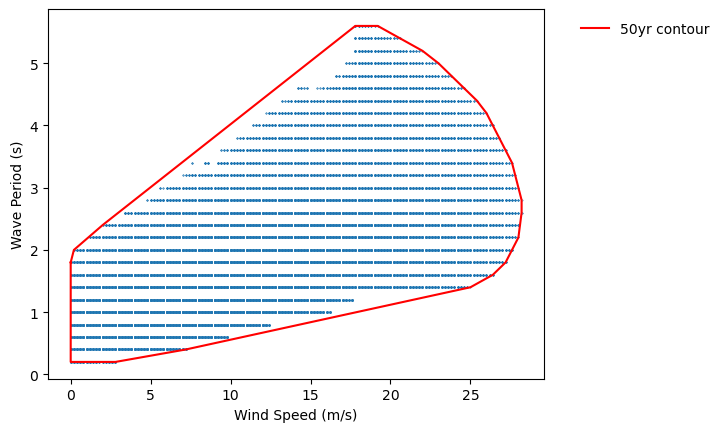

In [54]:
ProbSurfaceVariables=Results[414]
def PlotSingleCurve(ProbSurfaceVariables):
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    #get the outer boundary
    # Combine x and y points into a single array
    points = np.column_stack((x, y))

    # Compute the convex hull
    hull = ConvexHull(points)

    # Extract the outer boundary points
    outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)

    plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], 'r-', label='50yr contour')
            

    plt.scatter(x, y,s=0.1)

    plt.xlabel("Wind Speed (m/s)")
    plt.ylabel("Wave Height (m)")
    plt.ylabel("Wave Period (s)")
    #legend on the left, outside the plot
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')

PlotSingleCurve(ProbSurfaceVariables)

100%|██████████| 732/732 [00:24<00:00, 29.59it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


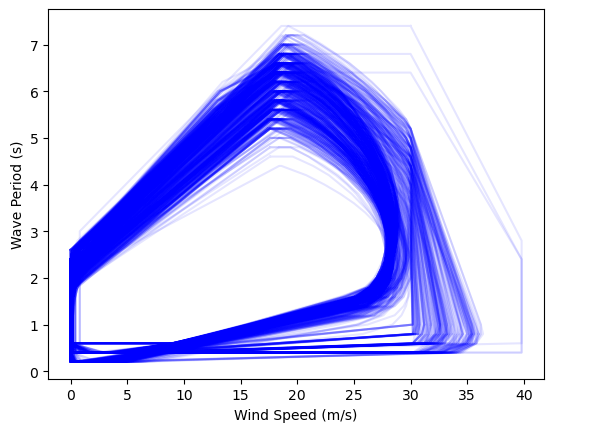

In [13]:
for i in tqdm(range(len(Results))):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    #get the outer boundary
    # Combine x and y points into a single array
    points = np.column_stack((x, y))

    # Compute the convex hull
    hull = ConvexHull(points)

    # Extract the outer boundary points
    outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)

    plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], 'b-', alpha=0.1)


#Overlap of all sites

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Wave Height (m)")

#legend on the left, outside the plot
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')


100%|██████████| 732/732 [00:24<00:00, 29.96it/s]


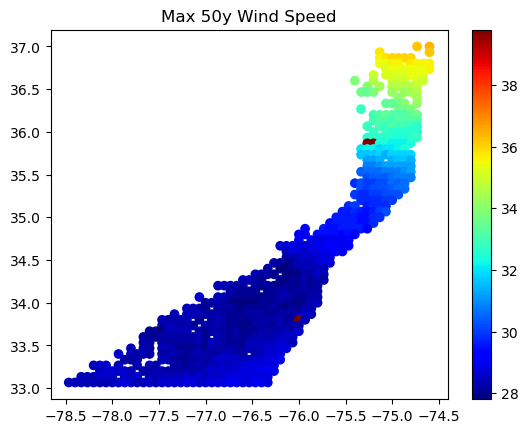

In [55]:
#Wave Data
Npz_Wave=np.load(PathWaveDate, allow_pickle=True)
LatLong=Npz_Wave["LatLong"]

Max50yWind=[]
Max50yWaveHeight=[]
for i in tqdm(range(len(Results))):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    Max50yWind.append(np.max(x))
    Max50yWaveHeight.append(np.max(y))

plt.scatter(LatLong[:,1], LatLong[:,0], c=Max50yWind, cmap='jet')
plt.colorbar()
plt.title("Max 50y Wind Speed")

#The indexed above 37 m/s of wind speed does not look consitent, lets exclude them
Max50yWind=np.array(Max50yWind)
Max50yWaveHeight=np.array(Max50yWaveHeight)
Idx=np.where(Max50yWind<37)[0]

In [20]:
Max50yWind=[]
Max50yWaveHeight=[]
for i in tqdm(Idx):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    Max50yWind.append(np.max(x))
    Max50yWaveHeight.append(np.max(y))


100%|██████████| 729/729 [00:23<00:00, 30.99it/s]


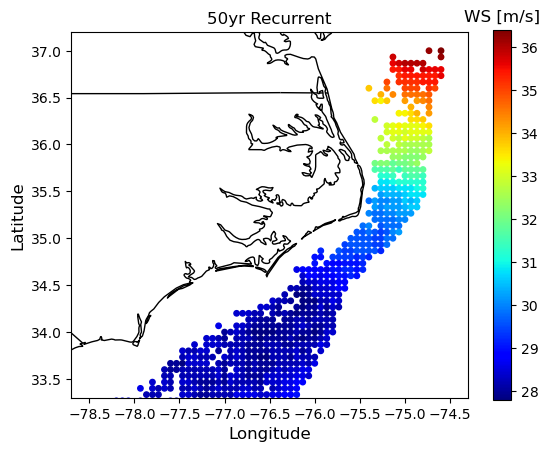

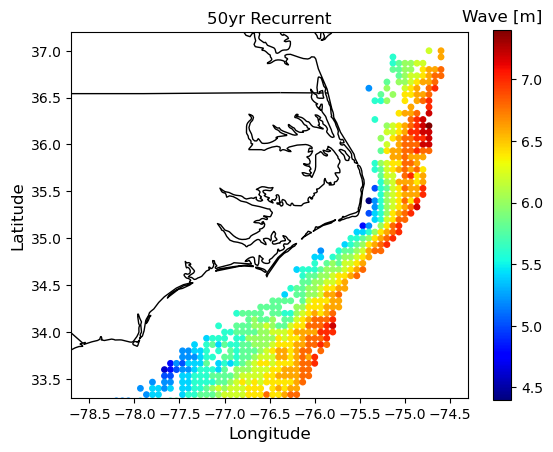

In [35]:
PlotGeneralGeoData(LatLong[Idx,:], Max50yWind, GeoDataPath, ColorBarTitle="WS [m/s]", Title="50yr Recurrent", SavePath=None, s=15, LatMaxMin=(33.3, 37.2), LongMaxMin=(-78.7, -74.3))
PlotGeneralGeoData(LatLong[Idx,:], Max50yWaveHeight, GeoDataPath, ColorBarTitle="Wave [m]", Title="50yr Recurrent", SavePath=None, s=15, LatMaxMin=(33.3, 37.2), LongMaxMin=(-78.7, -74.3))

100%|██████████| 729/729 [01:36<00:00,  7.56it/s]


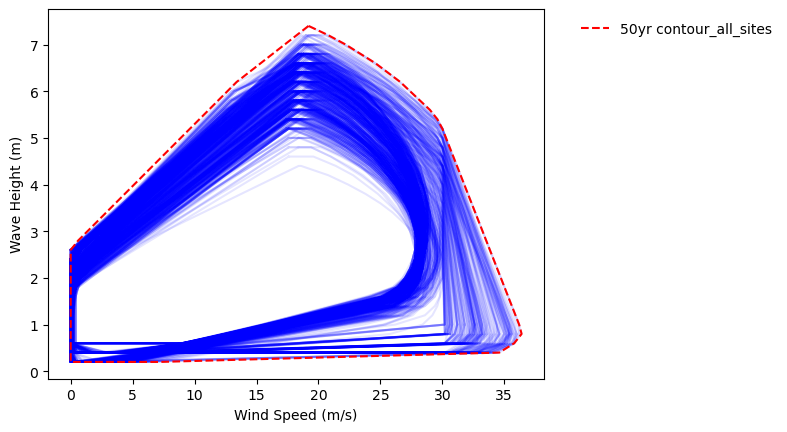

In [50]:
X_all=np.empty((0))
Y_all=np.empty((0))
for i in tqdm(Idx):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    X_all=np.concatenate((X_all, x))
    Y_all=np.concatenate((Y_all, y))
    #get the outer boundary
    # Combine x and y points into a single array
    points = np.column_stack((x, y))

    # Compute the convex hull
    hull = ConvexHull(points)

    # Extract the outer boundary points
    outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)

    plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], 'b-', alpha=0.1)


#Overlap of all sites
points = np.column_stack((np.array(X_all), np.array(Y_all)))
# Compute the convex hull
hull = ConvexHull(points)

# Extract the outer boundary points
outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)

df = pd.DataFrame({"WindSpeed":points[hull.vertices][:,0], "WaveHeight":points[hull.vertices][:,1]})
df.to_csv("./InputData/Wave/50yr_Wind_Wave.csv", index=False)

plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], 'r--', alpha=1, label="50yr contour_all_sites")

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Wave Height (m)")
# plt.ylabel("Wave Period (s)")
#legend on the left, outside the plot
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
X_all=np.empty((0))
Y_all=np.empty((0))
Z_all=np.empty((0))
for i in tqdm(Idx):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]#WS
    y=np.array(ProbSurfaceVariables)[:,1]#Wave height
    z=np.array(ProbSurfaceVariables)[:,2]#Wave period
    
    X_all=np.concatenate((X_all, x))
    Y_all=np.concatenate((Y_all, y))
    Z_all=np.concatenate((Z_all, z))

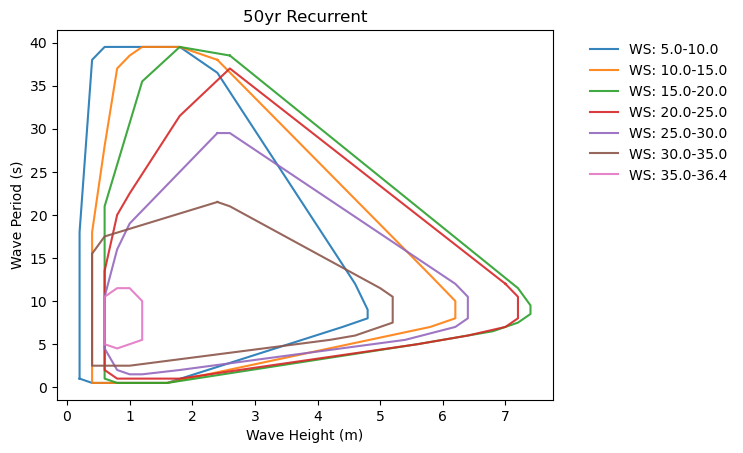

In [70]:
WS_Range=[5, 10, 15, 20,25,30,35,np.max(X_all)]
Dict={}
excel_writer = pd.ExcelWriter("./InputData/Wave/50yr_Wind_WaveHeightPeriod.xlsx", engine='xlsxwriter')

for Ws in range(len(WS_Range)-1):
    Idx_tmp=np.where((X_all>=WS_Range[Ws])*(X_all<WS_Range[Ws+1]))[0]
    points = np.column_stack((Y_all[Idx_tmp], Z_all[Idx_tmp]))
    hull = ConvexHull(points)
    outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)
    plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], alpha=0.9,label="WS: "+"{:.1f}".format(WS_Range[Ws])+"-"+"{:.1f}".format(WS_Range[Ws+1]))
    
    df=pd.DataFrame({"Wave Height":outer_boundary_points[:, 0], "Wave Period":outer_boundary_points[:, 1]})
    df.to_excel(excel_writer, sheet_name="WS "+"{:.1f}".format(WS_Range[Ws])+"-"+"{:.1f}".format(WS_Range[Ws+1]), index=False)
          
excel_writer.close()


plt.title("50yr Recurrent")
plt.xlabel("Wave Height (m)")
plt.ylabel("Wave Period (s)")
#legend on the left, outside the plot
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')

## 100yrs

In [9]:
Data=np.load("./InputData/Wave/EVA_100y_ProbSurfaceVariables.npz", allow_pickle=True)["Data"].item()
Results=Data["Results"]


100%|██████████| 732/732 [00:32<00:00, 22.43it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


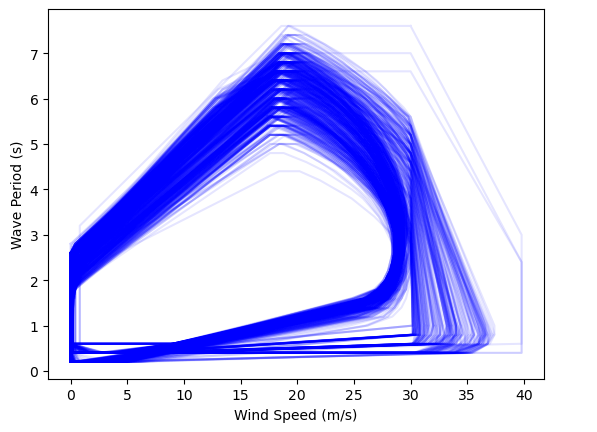

In [12]:
for i in tqdm(range(len(Results))):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    #get the outer boundary
    # Combine x and y points into a single array
    points = np.column_stack((x, y))

    # Compute the convex hull
    hull = ConvexHull(points)

    # Extract the outer boundary points
    outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)

    plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], 'b-', alpha=0.1)


#Overlap of all sites

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Wave Height (m)")
plt.ylabel("Wave Period (s)")
#legend on the left, outside the plot
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')


100%|██████████| 732/732 [00:26<00:00, 27.31it/s]


Text(0.5, 1.0, 'Max 100y Wind Speed')

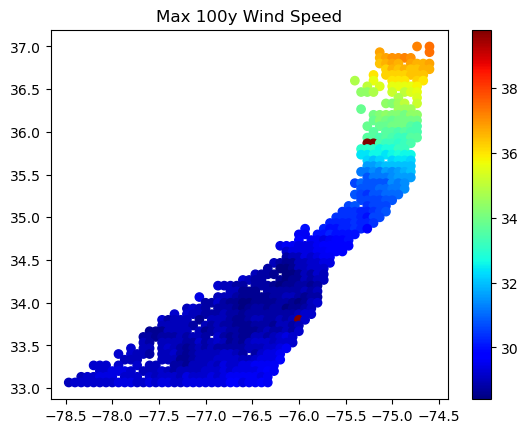

In [14]:
#Wave Data
Npz_Wave=np.load(PathWaveDate, allow_pickle=True)
LatLong=Npz_Wave["LatLong"]

Max100yWind=[]
Max100yWaveHeight=[]
for i in tqdm(range(len(Results))):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    Max100yWind.append(np.max(x))
    Max100yWaveHeight.append(np.max(y))

plt.scatter(LatLong[:,1], LatLong[:,0], c=Max100yWind, cmap='jet')
plt.colorbar()
plt.title("Max 100y Wind Speed")

In [15]:
#The indexed above 37 m/s of wind speed does not look consitent, lets exclude them
Max100yWind=np.array(Max100yWind)
Max100yWaveHeight=np.array(Max100yWaveHeight)
Idx=np.where(Max100yWind<39)[0]

Max100yWind=[]
Max100yWaveHeight=[]
for i in tqdm(Idx):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    Max100yWind.append(np.max(x))
    Max100yWaveHeight.append(np.max(y))


100%|██████████| 729/729 [00:26<00:00, 27.17it/s]


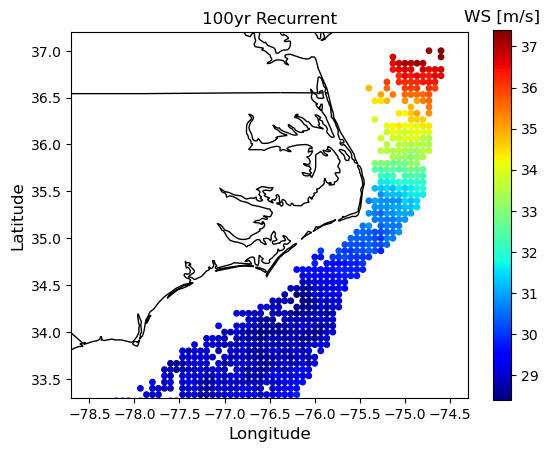

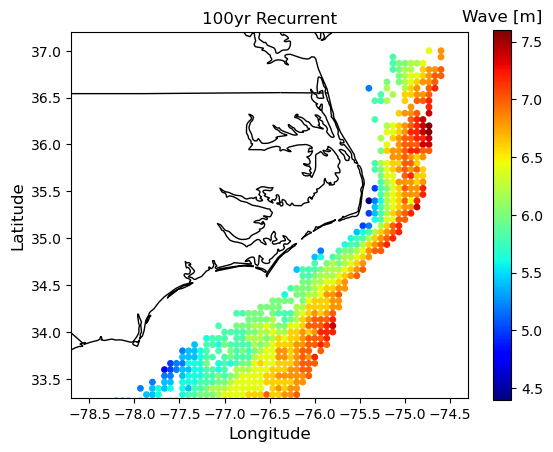

In [33]:
PlotGeneralGeoData(LatLong[Idx,:], Max100yWind, GeoDataPath, ColorBarTitle="WS [m/s]", Title="100yr Recurrent", SavePath=None, s=15, LatMaxMin=(33.3, 37.2), LongMaxMin=(-78.7, -74.3))
PlotGeneralGeoData(LatLong[Idx,:], Max100yWaveHeight, GeoDataPath, ColorBarTitle="Wave [m]", Title="100yr Recurrent", SavePath=None, s=15, LatMaxMin=(33.3, 37.2), LongMaxMin=(-78.7, -74.3))

100%|██████████| 729/729 [01:37<00:00,  7.50it/s]


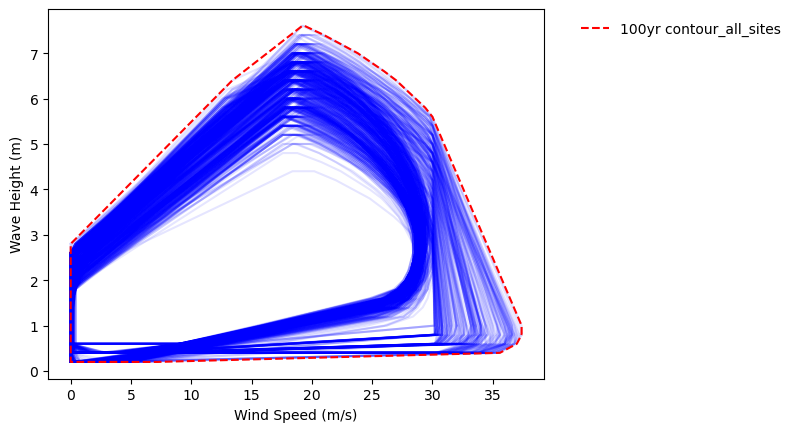

In [16]:
X_all=np.empty((0))
Y_all=np.empty((0))
for i in tqdm(Idx):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    X_all=np.concatenate((X_all, x))
    Y_all=np.concatenate((Y_all, y))
    #get the outer boundary
    # Combine x and y points into a single array
    points = np.column_stack((x, y))

    # Compute the convex hull
    hull = ConvexHull(points)

    # Extract the outer boundary points
    outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)

    plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], 'b-', alpha=0.1)


#Overlap of all sites
points = np.column_stack((np.array(X_all), np.array(Y_all)))
# Compute the convex hull
hull = ConvexHull(points)

# Extract the outer boundary points
outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)

df = pd.DataFrame({"WindSpeed":points[hull.vertices][:,0], "WaveHeight":points[hull.vertices][:,1]})
df.to_csv("./InputData/Wave/100yr_Wind_Wave.csv", index=False)

plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], 'r--', alpha=1, label="100yr contour_all_sites")

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Wave Height (m)")
# plt.ylabel("Wave Period (s)")
#legend on the left, outside the plot
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')


In [17]:
X_all=np.empty((0))
Y_all=np.empty((0))
Z_all=np.empty((0))
for i in tqdm(Idx):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]#WS
    y=np.array(ProbSurfaceVariables)[:,1]#Wave height
    z=np.array(ProbSurfaceVariables)[:,2]#Wave period
    
    X_all=np.concatenate((X_all, x))
    Y_all=np.concatenate((Y_all, y))
    Z_all=np.concatenate((Z_all, z))

100%|██████████| 729/729 [02:24<00:00,  5.06it/s]


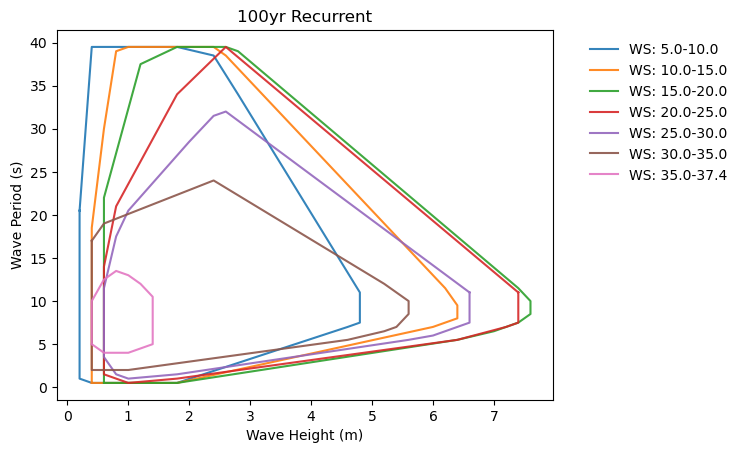

In [18]:
WS_Range=[5, 10, 15, 20,25,30,35,np.max(X_all)]
Dict={}
excel_writer = pd.ExcelWriter("./InputData/Wave/100yr_Wind_WaveHeightPeriod.xlsx", engine='xlsxwriter')

for Ws in range(len(WS_Range)-1):
    Idx_tmp=np.where((X_all>=WS_Range[Ws])*(X_all<WS_Range[Ws+1]))[0]
    points = np.column_stack((Y_all[Idx_tmp], Z_all[Idx_tmp]))
    hull = ConvexHull(points)
    outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)
    plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], alpha=0.9,label="WS: "+"{:.1f}".format(WS_Range[Ws])+"-"+"{:.1f}".format(WS_Range[Ws+1]))
    
    df=pd.DataFrame({"Wave Height":outer_boundary_points[:, 0], "Wave Period":outer_boundary_points[:, 1]})
    df.to_excel(excel_writer, sheet_name="WS "+"{:.1f}".format(WS_Range[Ws])+"-"+"{:.1f}".format(WS_Range[Ws+1]), index=False)
          
excel_writer.close()


plt.title("100yr Recurrent")
plt.xlabel("Wave Height (m)")
plt.ylabel("Wave Period (s)")
#legend on the left, outside the plot
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')